In [1]:
# import os 
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import lightning.pytorch as pl
import torch
import hydra
import numpy as np  
from hydra import compose, initialize
from omegaconf import OmegaConf,DictConfig
import datetime
import matplotlib.pyplot as plt
import xarray as xr
from celluloid import Camera
import datetime
import subprocess
import sys
import os
from hydra import compose, initialize
from omegaconf import OmegaConf
from visualization import rollout
import pickle
import matplotlib

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config",overrides=["experiment=one_month_multiple_variable_v100"])
scratch = os.environ['SCRATCH']
work = os.environ['WORK']

In [2]:
def compute_predict(run_id,delta,normalization,predict_length,var_index):
    #return unnormazlied and climatology-normalized data
    test = IPSL_DCPP('test',
                     lead_time_months=1,
                     surface_variables=cfg.experiment.surface_variables,
                     depth_variables=cfg.experiment.depth_variables,
                     generate_statistics=False,
                     delta=delta,
                     normalization=normalization
                    )
    dataloader = torch.utils.data.DataLoader(test,batch_size=1,shuffle=False,num_workers=1)
    out = subprocess.run(f'ls -tr {scratch}/checkpoint_{run_id}/ | tail -n 1',shell=True,capture_output=True,text=True)
    path = out.stdout.strip("\n")
    checkpoint_path = torch.load(f'{scratch}/checkpoint_{run_id}/{path}',map_location=torch.device('cpu'))
    model = hydra.utils.instantiate(
        cfg.experiment.module,
        backbone=hydra.utils.instantiate(cfg.experiment.backbone),
        dataset=test
    )
    model.load_state_dict(checkpoint_path['state_dict'])
    trainer = pl.Trainer(fast_dev_run=predict_length)
    output = trainer.predict(model, dataloader)
    
    lat_coeffs_equi = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])
    lat_coeffs =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]
 #   f, axs = plt.subplots(3, 4, figsize=(16, 6))
 #   axs = axs.flatten()
    ds = xr.open_dataset(test.files[0])
    shell = ds.isel(time=0)

    subset_lats = lat_coeffs[:,:,:,85:110,:]
    subset_lats = lat_coeffs
    sub_shell = shell.isel(lat=slice(85,110),lon=slice(25,50))
    sub_shell = shell
    
    #for index in range(0,len(output),3):
    #    pred = output[index][-2]
    #    batch = output[index][-1]
    #    pred,batch = test.denormalize(pred,batch)
    #    predictions = pred['next_state_surface'].squeeze()[var_index]
    #    batch_data = batch['next_state_surface'].squeeze()[var_index]
     #   predictions = pred['next_state_surface'].squeeze()[:,var_index]
     #   batch_data = batch['next_state_surface'].squeeze()[:,var_index]
        #sub_shell[surface_var_name]['time'].data = next(iter(test_dataloader))['time'][0]
        #sub_shell[surface_var_name].data = predictions
        # xx = shell[surface_var_name].plot.pcolormesh(ax=axs[index//3],cmap='ocean',add_colorbar=False,add_labels=False)
    predictions_out = []
    batch_out = []
    for index in range(0,len(output)):
        pred = output[index][-2]
        batch = output[index][-1]
        print(pred['next_state_surface'].shape)
        if(test.delta == True):
            pred['next_state_surface'] = pred['next_state_surface'].unsqueeze(0)*np.expand_dims(dataloader.dataset.surface_delta_stds,0) + batch['state_surface']
            batch['next_state_surface'] = batch['next_state_surface'].unsqueeze(0)*np.expand_dims(dataloader.dataset.surface_delta_stds,0) + batch['state_surface']
        print(pred['next_state_surface'].shape)
        pred,batch = test.denormalize(pred,batch)
        predictions = pred['next_state_surface'].squeeze()[var_index]
        batch_data = batch['next_state_surface'].squeeze()[var_index]
      #  predictions = pred['next_state_surface'].squeeze()[:,var_index]
      #  batch_data = batch['next_state_surface'].squeeze()[:,var_index]
        predictions_out.append(predictions)
        batch_out.append(batch_data)
    return (predictions_out,batch_out)         
#         pred_ax = axs[index//3].pcolormesh(predictions,cmap='ocean',vmin=0,vmax=torch.max(batch_data))
#        # pred_ax = axs[index//3].pcolormesh(predictions,cmap='ocean')        
#         axs[index//3].set_title(f'2014-{index+1}')
#         #sub_shell[surface_var_name].data = batch_data
#         #shell[surface_var_name].plot.pcolormesh(ax=axs[(index//3) + 4],cmap='ocean',add_colorbar=False,add_labels=False)
#         batch_ax = axs[index//3+4].pcolormesh(batch_data ,cmap='ocean',vmin=0,vmax=torch.max(batch_data))
#        # batch_ax = axs[index//3+4].pcolormesh(batch_data ,cmap='ocean')


#         rmse = torch.sqrt((predictions - batch_data).pow(2).mul(subset_lats))
#         #sub_shell[surface_var_name].data = mse.squeeze()
#         #shell[surface_var_name].plot.pcolormesh(ax=axs[(index//3) + 8],cmap='ocean',vmax=1e7,vmin=0)
#         rmse_ax = axs[(index//3) + 8].pcolormesh(rmse.squeeze(),cmap='ocean',vmin=0)
#         axs[(index//3) + 8].set_xlabel('')
#         axs[(index//3) + 8].set_title('')
#         axs[(index//3) + 8].set_ylabel('')
#     f.colorbar(pred_ax, ax=axs[index//3],cmap='ocean',location='right')
#     f.colorbar(batch_ax, ax=axs[index//3+4],cmap='ocean',location='right')
#     f.colorbar(rmse_ax, ax=axs[index//3+8],cmap='ocean',location='right')
#     # rollout_data = rollout(rollout_length,dataloader,model)
#     # denormalized_data = [dataloader.dataset.denormalize(rollout_data[0][i],rollout_data[1][i]) for i in range(rollout_length)]
#     # denorm_pred = [x[0] for x in denormalized_data]
#     # denorm_batch = [x[1] for x in denormalized_data]
#     # print(len(rollout_data[0]))
#     # if(normalization == 'normal'):
#     #     climatology_surface_means = np.load('data/climatology_surface_means.npy')
#     #     climatology_surface_stds = np.broadcast_to(np.expand_dims(np.load(f'data/climatology_surface_stds.npy'),(-2,-1)),(12,91,143,144))
#     #     pred_climatology_normalized = []
#     #     batch_climatology_normalized = []
#     #     for i in range(rollout_length):
#     #         pred_climatology_normalized.append((denormalized_data[i][0]['next_state_surface'] - climatology_surface_means[(i+1) % 12]) / climatology_surface_stds[(i+1) % 12])
#     #         batch_climatology_normalized.append((denormalized_data[i][1]['next_state_surface'] - climatology_surface_means[(i+1) % 12]) / climatology_surface_stds[(i+1) % 12])    
#     # else:
#     #     pred_climatology_normalized = [x['next_state_surface'] for x in rollout_data[0]]
#     #     batch_climatology_normalized = [x['next_state_surface'] for x in rollout_data[1]]
#     return f


In [3]:
variable_name = 'cVeg'
test = IPSL_DCPP('test',
                 lead_time_months=1,
                 surface_variables=cfg.experiment.surface_variables,
                 depth_variables=cfg.experiment.depth_variables,
                 generate_statistics=False,
                 delta=False,
                 normalization='normal'
                )
var_index=test.surface_variables.index(variable_name)


In [4]:
rollout_length = 12
predictions_gpp = [#compute_predict('6a0adc60',False,'normal',rollout_length,var_index),
             #compute_predict('4c605229',False,'climatology',rollout_length,var_index),
             #compute_predict('2ab31632',False,'spatial_normal',rollout_length,var_index),
             #compute_predict('153d9428',True,'normal',rollout_length,var_index),
 compute_predict('edb26faa',True,'climatology',rollout_length,var_index),
             compute_predict('9cbb1f05',True,'climatology',rollout_length,var_index)]
            #compute_predict('eb38bfdd',True,'spatial_normal',rollout_length,var_index)]

/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/gpfsdswork/projects/rech/mlr/udy16au/miniconda3/envs/env_gpu5/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, 

Predicting DataLoader 0: 100%|██████████| 12/12 [01:06<00:00,  0.18it/s]
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])


/gpfsdswork/projects/rech/mlr/udy16au/ipsl_dcpp/ipsl_dcpp/model/ipsl_dataset.py:228: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  denorm_surface = lambda x,month_index: x.to(device)*torch.from_numpy(self.surface_stds[month_index]).to(device) + torch.from_numpy(self.surface_means[month_index]).to(device)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 12 batch(es). Logging and checkpointing is suppressed.
SLURM auto-requeueing enabled. Setting signal handlers.

Predicting DataLoader 0: 100%|██████████| 12/12 [01:06<00:00,  0.18it/s]
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])
torch.Size([1, 91, 143, 144])
torch.Size([1, 1, 91, 143, 144])


In [5]:
#recuperate deltas ?
predict_deltas = []
batch_deltas = []
model_index = 0
prediction_length = 12
for rollout_index in range(prediction_length-1):
    predict_deltas.append((predictions_gpp[model_index][0][rollout_index+1] - predictions_gpp[model_index][1][rollout_index]) )
    batch_deltas.append((predictions_gpp[model_index][1][rollout_index+1] - predictions_gpp[model_index][1][rollout_index]) )


In [6]:
climatology_surface_means = np.load('../data/climatology_surface_means.npy')
climatology_surface_stds = np.broadcast_to(np.expand_dims(np.load(f'../data/climatology_surface_stds.npy'),(-2,-1)),(12,91,143,144))

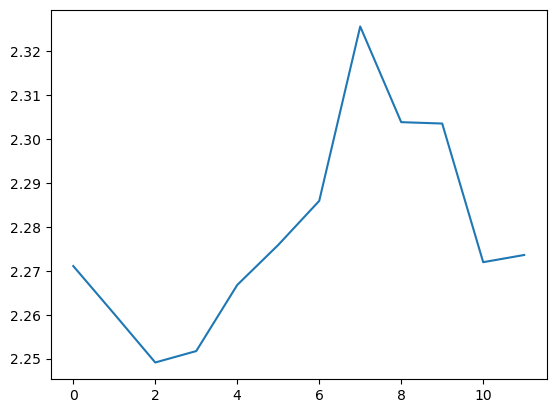

In [7]:
plt.plot(np.nanmean(climatology_surface_means[:,var_index],axis=(-1,-2)))

In [8]:
predictions_gpp[model_index][1][0].shape

torch.Size([143, 144])

In [9]:
climatology_surface_means[6,var_index,120]

array([           nan,            nan, 1.49412501e+00, 4.97810505e-02,
       4.74371351e-02, 2.29439661e-01, 2.56180930e+00, 2.63051701e+00,
       4.95623493e+00, 5.63219166e+00, 4.07270861e+00, 2.22050452e+00,
       1.44294572e+00, 4.06492519e+00, 9.22990263e-01, 3.41719460e+00,
       1.78360498e+00, 2.10171103e+00, 2.56218505e+00, 4.14772940e+00,
       2.42276192e+00, 2.44511914e+00, 3.89858222e+00, 4.76310444e+00,
       2.45615816e+00, 3.41738439e+00, 1.87065196e+00, 2.10204291e+00,
       1.45434904e+00, 6.61896884e-01, 8.46653044e-01, 1.55399334e+00,
       1.73682475e+00, 1.37780273e+00, 2.13526034e+00, 3.44709969e+00,
       2.17530680e+00, 1.11956775e+00, 5.46314955e-01, 3.69771123e-01,
       4.89769638e-01, 5.53254902e-01, 4.43219513e-01, 8.27584445e-01,
       7.48301864e-01, 5.21616697e-01, 5.18786132e-01, 4.26453531e-01,
       3.63381743e-01, 3.65888506e-01, 7.91981101e-01, 8.25182676e-01,
       6.77174509e-01, 6.88580930e-01, 8.47958207e-01, 5.07742345e-01,
      

In [10]:
climatology_surface_means.shape

(12, 91, 143, 144)

In [11]:
climatology_surface_means[6][var_index][120]

array([           nan,            nan, 1.49412501e+00, 4.97810505e-02,
       4.74371351e-02, 2.29439661e-01, 2.56180930e+00, 2.63051701e+00,
       4.95623493e+00, 5.63219166e+00, 4.07270861e+00, 2.22050452e+00,
       1.44294572e+00, 4.06492519e+00, 9.22990263e-01, 3.41719460e+00,
       1.78360498e+00, 2.10171103e+00, 2.56218505e+00, 4.14772940e+00,
       2.42276192e+00, 2.44511914e+00, 3.89858222e+00, 4.76310444e+00,
       2.45615816e+00, 3.41738439e+00, 1.87065196e+00, 2.10204291e+00,
       1.45434904e+00, 6.61896884e-01, 8.46653044e-01, 1.55399334e+00,
       1.73682475e+00, 1.37780273e+00, 2.13526034e+00, 3.44709969e+00,
       2.17530680e+00, 1.11956775e+00, 5.46314955e-01, 3.69771123e-01,
       4.89769638e-01, 5.53254902e-01, 4.43219513e-01, 8.27584445e-01,
       7.48301864e-01, 5.21616697e-01, 5.18786132e-01, 4.26453531e-01,
       3.63381743e-01, 3.65888506e-01, 7.91981101e-01, 8.25182676e-01,
       6.77174509e-01, 6.88580930e-01, 8.47958207e-01, 5.07742345e-01,
      

In [12]:
climatology_deltas = []
for i in range(11):
    climatology_deltas.append((climatology_surface_means[i+1,var_index] - climatology_surface_means[i,var_index]))

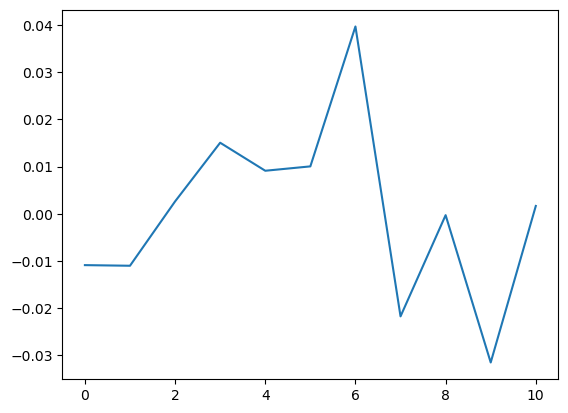

In [13]:
plt.plot(np.nanmean(climatology_deltas[:],axis=(-1,-2)))

In [14]:
np.nanmean(climatology_deltas[:],axis=(-1,-2)) 

array([-0.01092277, -0.01105624,  0.0026008 ,  0.01506375,  0.00911494,
        0.01004166,  0.03974618, -0.02180306, -0.00031477, -0.03159294,
        0.00164001], dtype=float32)

In [15]:
test.surface_delta_stds.squeeze()[var_index]

0.008890553

In [16]:
lat_coeffs_equi = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])

lat_coeffs =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]
def rmse(x, y,coeffs):
    return ((x-y).mul(coeffs)**2)**.5
    

In [17]:
rmse_1 = rmse(predictions_gpp[model_index][0][0],predictions_gpp[model_index][1][0],lat_coeffs)
rmse_2 = rmse(predictions_gpp[model_index][0][6],predictions_gpp[model_index][1][6],lat_coeffs)

In [28]:
diff1 = predictions_gpp[model_index][0][0] - predictions_gpp[model_index][1][0]
diff2 = predictions_gpp[model_index][0][6] - predictions_gpp[model_index][1][6]

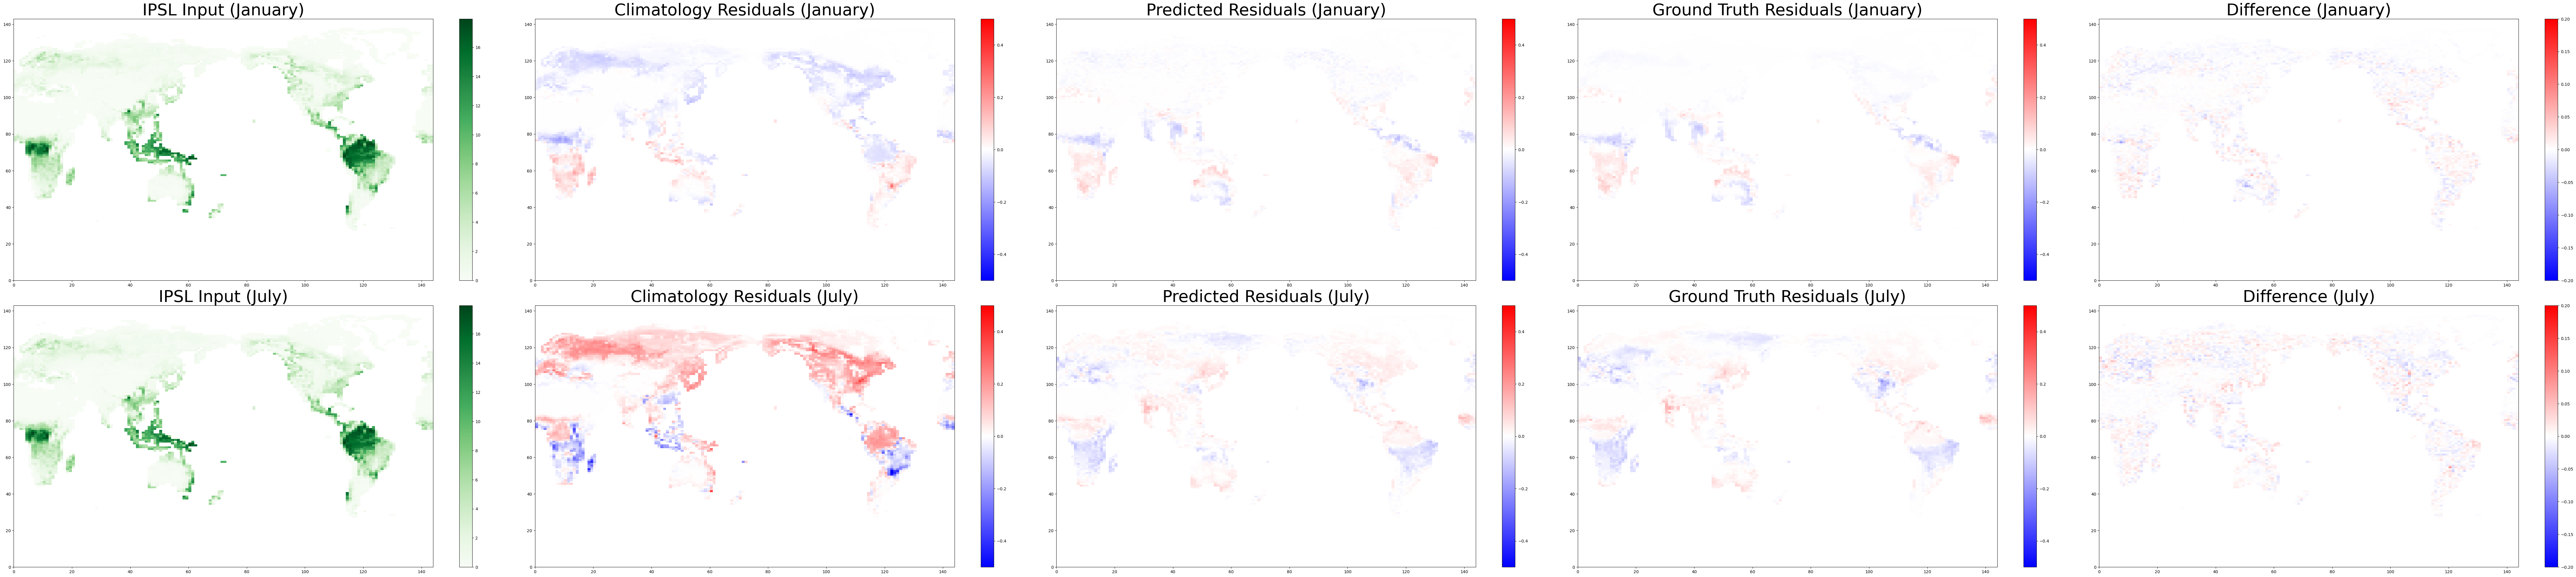

In [30]:
#input, clim delta, pred delta, gf delta, error map
f, axs = plt.subplots(2, 5, figsize=(90, 20))
axs = axs.flatten()
vmax = 0.5
vmin = -0.5
ax0 = axs[0].pcolormesh(predictions_gpp[model_index][1][0],cmap='Greens')
ax1 = axs[1].pcolormesh(climatology_deltas[0],label='Predicted Deltas January',vmax=vmax,vmin=vmin,cmap='bwr')
ax2 = axs[2].pcolormesh(predict_deltas[0],label='Predicted Deltas January',vmax=vmax,vmin=vmin,cmap='bwr')
ax3 = axs[3].pcolormesh(batch_deltas[0],label='IPSL Deltas January',vmax=vmax,vmin=vmin,cmap='bwr')
ax4 = axs[4].pcolormesh(diff1,label='RMSE',vmax=0.2,vmin=-.2,cmap='bwr')

ax5 = axs[5].pcolormesh(predictions_gpp[model_index][1][6],cmap='Greens')
ax6 = axs[6].pcolormesh(climatology_deltas[6],label='Predicted Deltas July',vmax=vmax,vmin=vmin,cmap='bwr')
ax7 = axs[7].pcolormesh(predict_deltas[6],label='Predicted Deltas July',vmax=vmax,vmin=vmin,cmap='bwr')
ax8 = axs[8].pcolormesh(batch_deltas[6],vmax=vmax,vmin=vmin,cmap='bwr')
ax9 = axs[9].pcolormesh(diff2,vmax=0.2,vmin=-.2,cmap='bwr')

f.colorbar(ax0, 
           ax=axs[0],
           cmap='Greens',
           location='right',)
f.colorbar(ax1, 
           ax=axs[1],
           cmap='bwr',
           location='right',)
f.colorbar(ax2, 
           ax=axs[2],
           cmap='bwr',
           location='right',)
f.colorbar(ax3, 
           ax=axs[3],
           cmap='bwr',
           location='right',)
f.colorbar(ax4, 
           ax=axs[4],
           cmap='Reds',
           location='right',)
f.colorbar(ax5, 
           ax=axs[5],
           cmap='Greens',
           location='right',)
f.colorbar(ax6, 
           ax=axs[6],
           cmap='bwr',
           location='right',)
f.colorbar(ax7, 
           ax=axs[7],
           cmap='bwr',
           location='right',)
f.colorbar(ax8, 
           ax=axs[8],
           cmap='bwr',
           location='right',)
f.colorbar(ax9, 
           ax=axs[9],
           cmap='Reds',
           location='right',)
f.tight_layout(pad=4)
axs[0].set_title('IPSL Input (January)',fontsize=40)
axs[1].set_title('Climatology Residuals (January)',fontsize=40)
axs[2].set_title('Predicted Residuals (January)',fontsize=40)
axs[3].set_title('Ground Truth Residuals (January)',fontsize=40)
axs[4].set_title('Difference (January)',fontsize=40)
axs[5].set_title('IPSL Input (July)',fontsize=40)
axs[6].set_title('Climatology Residuals (July)',fontsize=40)
axs[7].set_title('Predicted Residuals (July)',fontsize=40)
axs[8].set_title('Ground Truth Residuals (July)',fontsize=40)
axs[9].set_title('Difference (July)',fontsize=40)
# f.suptitle('Carbon Stock Delta Comparison',fontsize=60)
# axs[(i*3)+1].pcolormesh(batch_deltas[i])
# axs[(i*3)+2].pcolormesh(cveg_climatology[i])
# axs[0].pcolormesh(predict_deltas[i])
# axs[(i*3)+1].pcolormesh(batch_deltas[i])
# axs[(i*3)+2].pcolormesh(cveg_climatology[i])
# axs[0].pcolormesh(predict_deltas[i])
# axs[(i*3)+1].pcolormesh(batch_deltas[i])
# axs[(i*3)+2].pcolormesh(cveg_climatology[i])
# axs[0].pcolormesh(predict_deltas[i])
# axs[(i*3)+1].pcolormesh(batch_deltas[i])
# axs[(i*3)+2].pcolormesh(cveg_climatology[i])
f.savefig('delta_comparison')

In [69]:
cveg_climatology = climatology_surface_means[:,var_index]

In [77]:
np.nanmean(cveg_climatology,axis=(-1,-2))

array([2.2711053, 2.2601826, 2.2491264, 2.2517273, 2.2667909, 2.2759058,
       2.2859476, 2.3256936, 2.3038905, 2.303576 , 2.2719827, 2.2736228],
      dtype=float32)

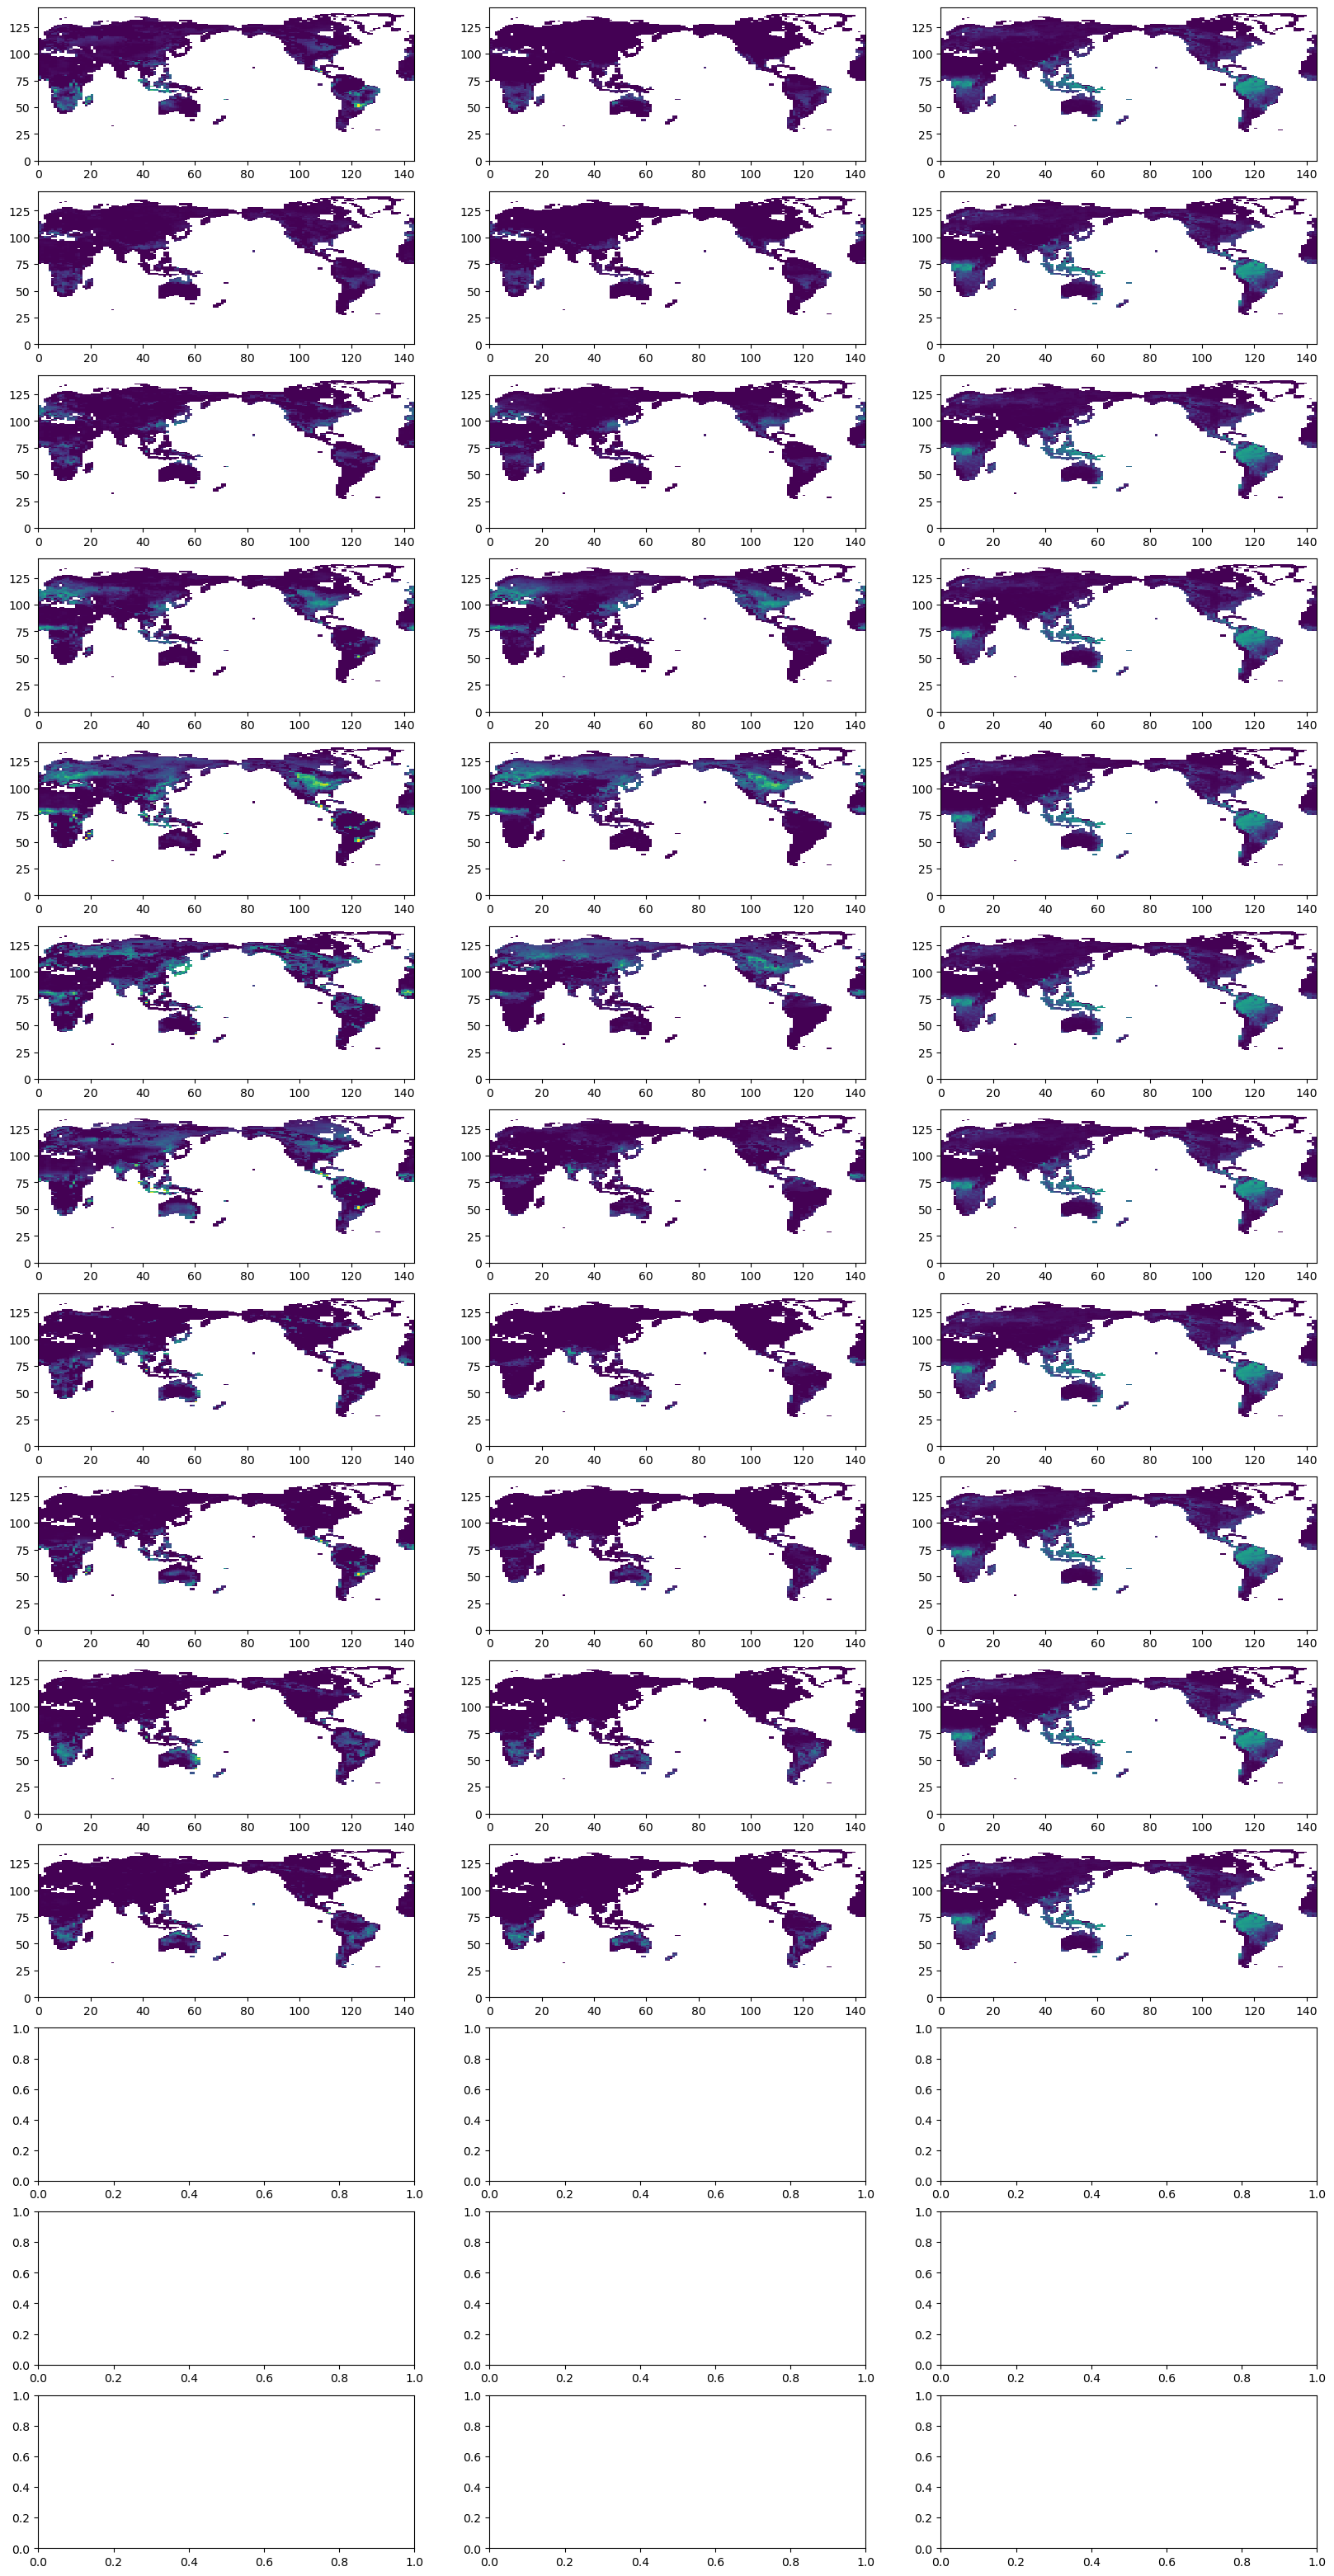

In [71]:
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)
f, axs = plt.subplots(14, 3, figsize=(20, 40))
axs = axs.flatten()
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)
for i in range(0,11):
    axs[i*3].pcolormesh(predict_deltas[i],vmin=0,vmax=30)
    axs[(i*3)+1].pcolormesh(batch_deltas[i],vmin=0,vmax=30)
    axs[(i*3)+2].pcolormesh(cveg_climatology[i],vmin=0,vmax=30)


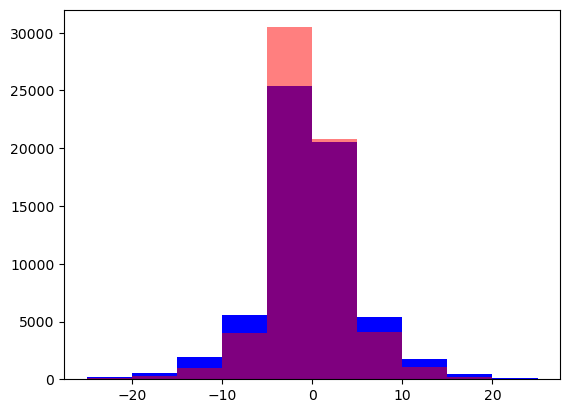

In [100]:
import numpy as np
import matplotlib.pyplot as plt
x = np.stack(predict_deltas).flatten().flatten()
n, bins, patches = plt.hist(x,range=(-25,25),color='blue')

plt.show()

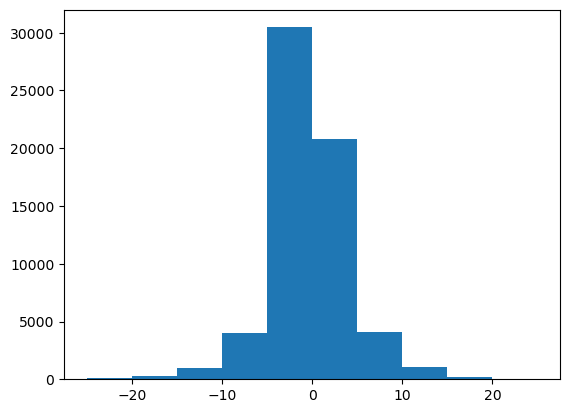

In [6]:
test = IPSL_DCPP('test',
                 lead_time_months=1,
                 surface_variables=cfg.experiment.surface_variables,
                 depth_variables=cfg.experiment.depth_variables,
                 generate_statistics=False,
                 delta=False,
                 normalization='normal'
                )

In [7]:
def rmse(x, y,coeffs):
    return ((x-y).mul(coeffs)**2)**.5
    

In [24]:
print(lat_coeffs.shape)

torch.Size([1, 1, 1, 143, 1])


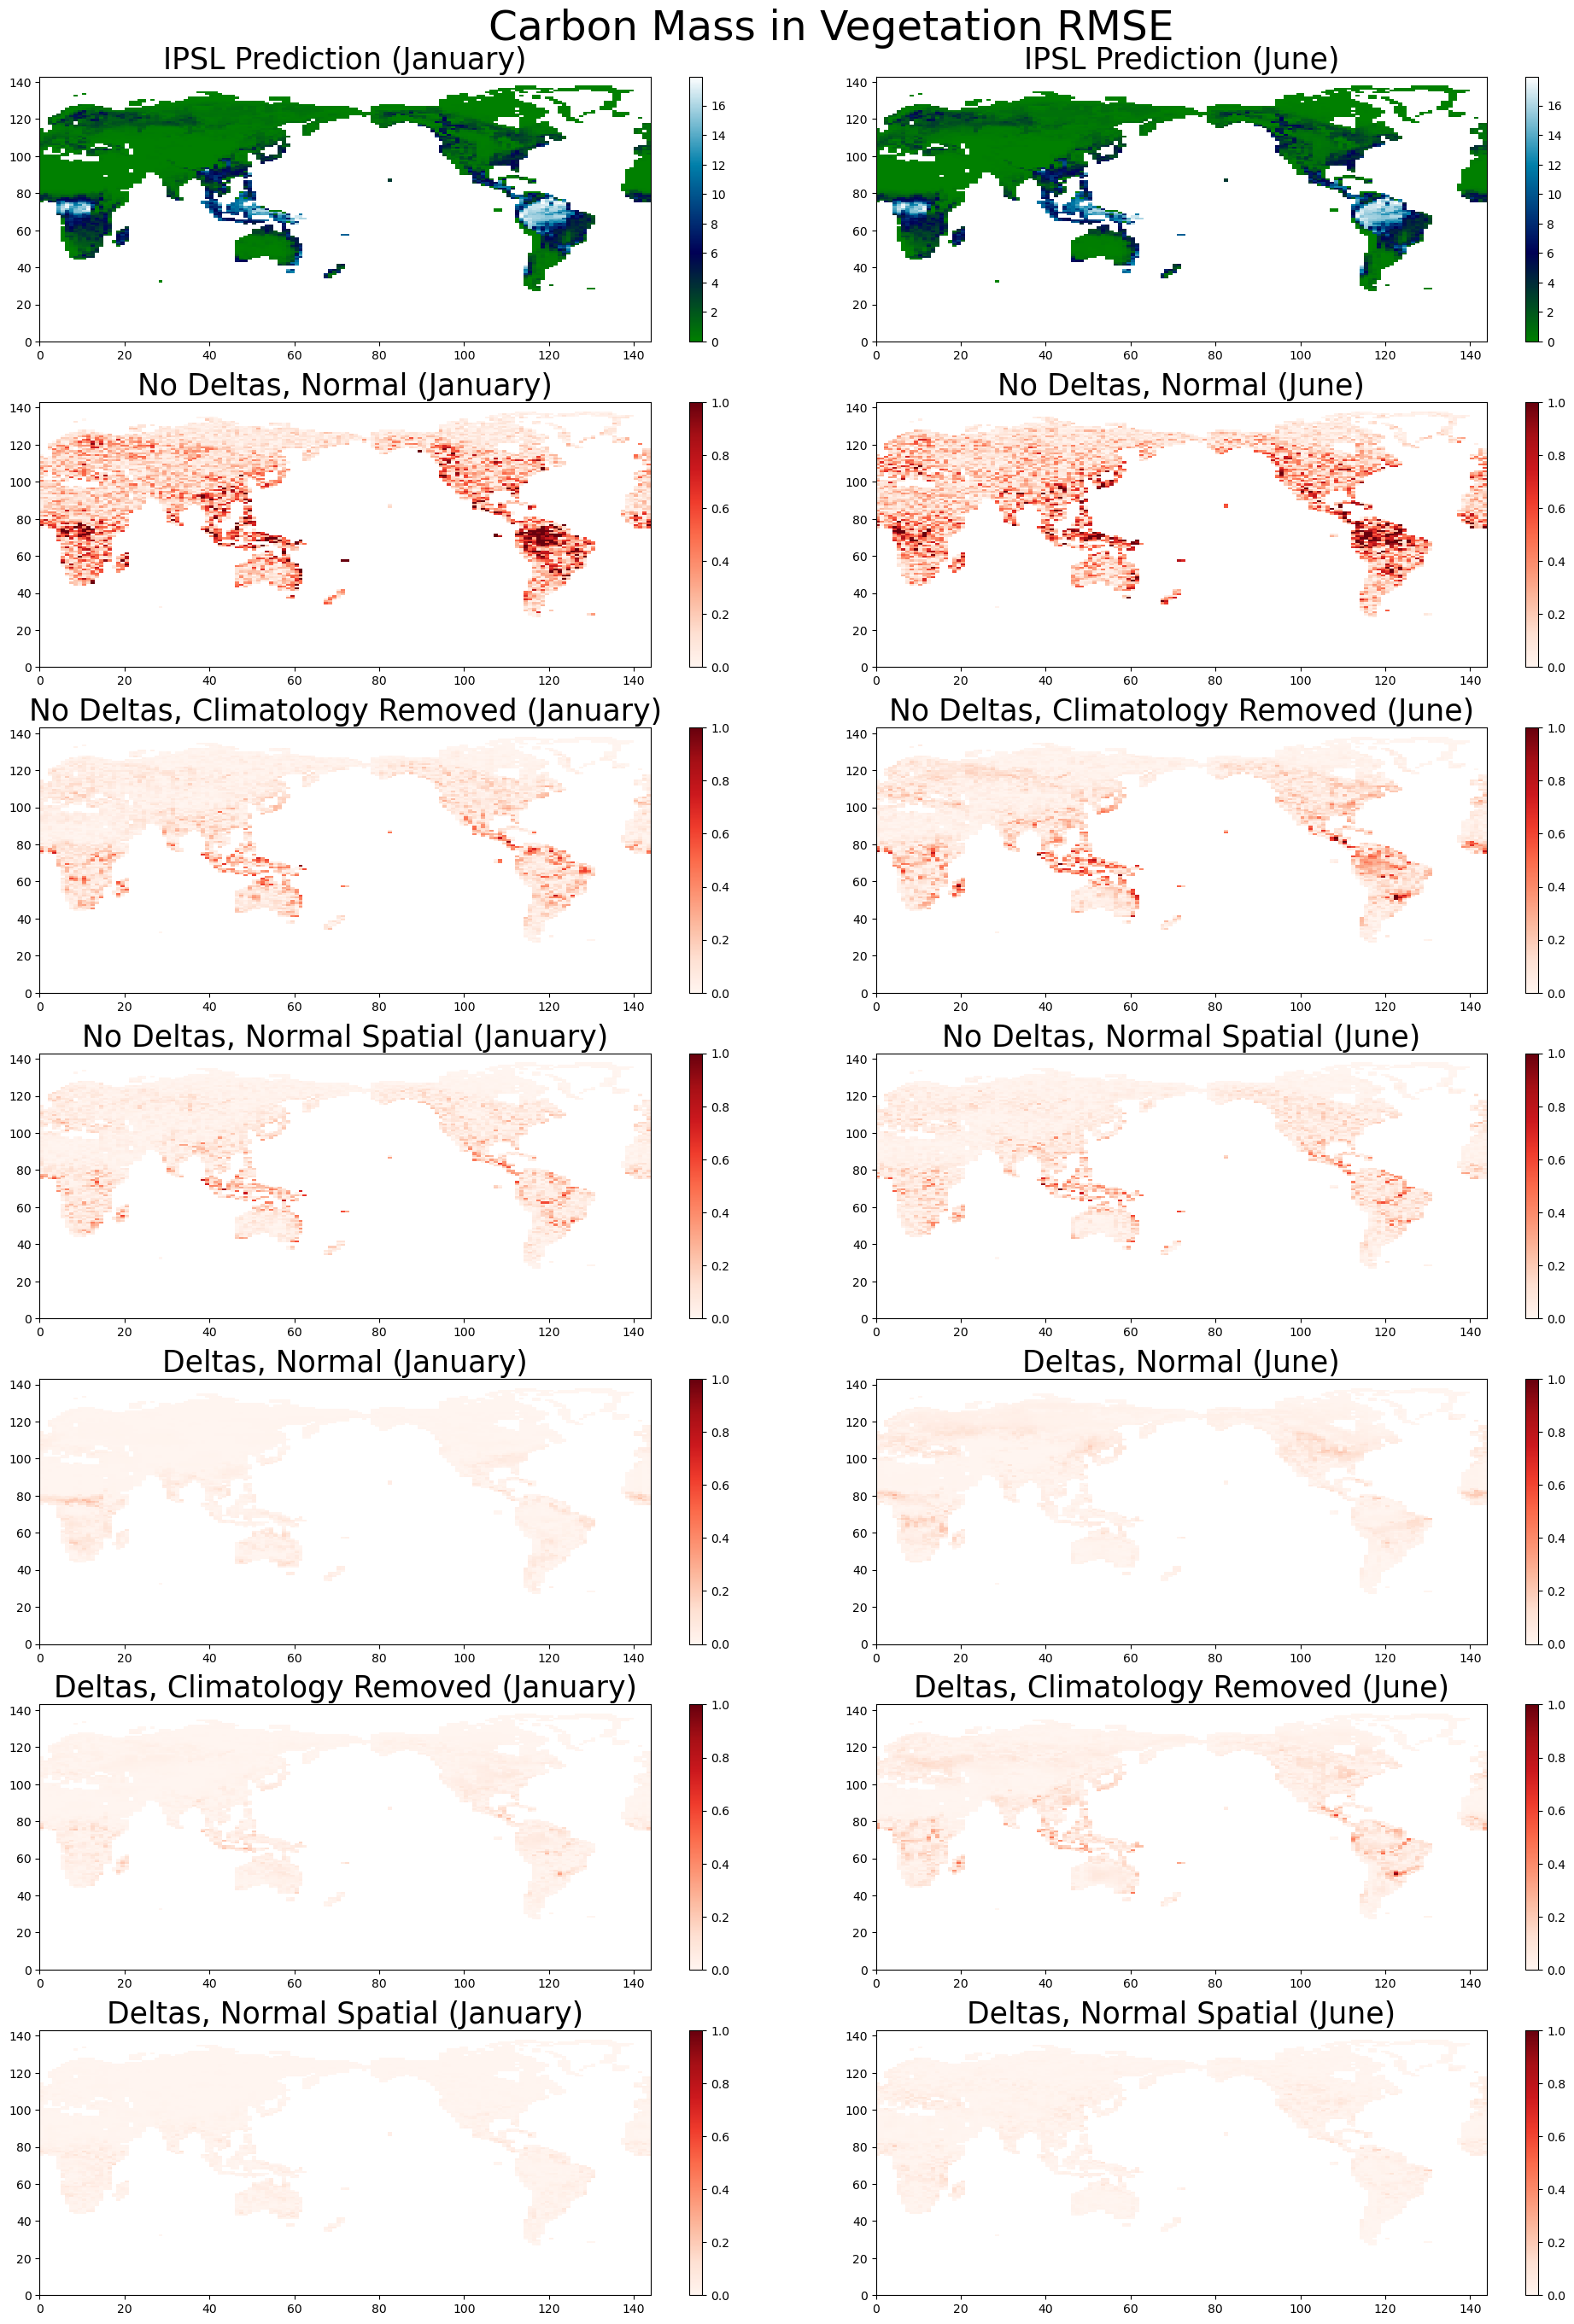

In [31]:
lat_coeffs_equi = torch.tensor([torch.cos(x) for x in torch.arange(-torch.pi/2, torch.pi/2, torch.pi/143)])
lat_coeffs =  (lat_coeffs_equi/lat_coeffs_equi.mean())[None, None, None, :, None]
f, axs = plt.subplots(7, 2, figsize=(20, 28))
axs = axs.flatten()
ds = xr.open_dataset(test.files[0])
shell = ds.isel(time=0)

subset_lats = lat_coeffs[:,:,:,85:110,:]
subset_lats = lat_coeffs
sub_shell = shell.isel(lat=slice(85,110),lon=slice(25,50))
sub_shell = shell
f.suptitle('Carbon Mass in Vegetation RMSE', fontsize=35)

maximum = torch.max(torch.nan_to_num(torch.from_numpy(np.stack(predictions_gpp[0][1])),0))
f.tight_layout(pad=3) 
axs[2].set_title('No Deltas, Normal (January)', fontsize=25)
axs[4].set_title('No Deltas, Climatology Removed (January)', fontsize=25)
axs[6].set_title('No Deltas, Normal Spatial (January)', fontsize=25)
axs[8].set_title('Deltas, Normal (January)', fontsize=25)
axs[10].set_title('Deltas, Climatology Removed (January)', fontsize=25)
axs[12].set_title('Deltas, Normal Spatial (January)', fontsize=25)
axs[3].set_title('No Deltas, Normal (June)', fontsize=25)
axs[5].set_title('No Deltas, Climatology Removed (June)', fontsize=25)
axs[7].set_title('No Deltas, Normal Spatial (June)', fontsize=25)
axs[9].set_title('Deltas, Normal (June)', fontsize=25)
axs[11].set_title('Deltas, Climatology Removed (June)', fontsize=25)
axs[13].set_title('Deltas, Normal Spatial (June)', fontsize=25)
axs[0].set_title('IPSL Prediction (January)', fontsize=25)
axs[1].set_title('IPSL Prediction (June)', fontsize=25)
#axs[2].set_title('July', rotation=0, size='large')
#axs[3].set_title('October', rotation=0, size='large')
batch_axs = []
for index in range(0,12,6):
  #  pred_ax = axs[index//3].pcolormesh(predictions_gpp[0][0][index],cmap='ocean',vmin=0,vmax=maximum)
#        # pred_ax = axs[index//3].pcolormesh(predictions,cmap='ocean')        
#         axs[index//3].set_title(f'2014-{index+1}')
#         #sub_shell[surface_var_name].data = batch_data
#         #shell[surface_var_name].plot.pcolormesh(ax=axs[(index//3) + 4],cmap='ocean',add_colorbar=False,add_labels=False)
    batch_ax = axs[index//6].pcolormesh(predictions_gpp[0][1][index],
                                        cmap='ocean',
                                        vmin=0,
                                        vmax=maximum,)
                                        #norm=matplotlib.colors.LogNorm())
#        # batch_ax = axs[index//3+4].pcolormesh(batch_data ,cmap='ocean')
    batch_axs.append(batch_ax)
   # rmse = torch.nanmean((predictions_gpp[1][0][index] - predictions_gpp[0][0][index]).mul(subset_lats)**2)**.5

#         #sub_shell[surface_var_name].data = mse.squeeze()
    #shell[surface_var_name].plot.pcolormesh(ax=axs[(index//3) + 8],cmap='ocean',vmax=1e7,vmin=0)
  #  rmse_ax = axs[(index//3) + 4].pcolormesh(rmse(predictions_gpp[0][1][index],predictions_gpp[0][0][index],subset_lats).squeeze(),cmap='bwr',vmin=0)
    models = []
    for model_index in range(6):
        model_map = axs[(index//6) + (model_index+1)*2].pcolormesh(
            rmse(predictions_gpp[model_index][1][index],predictions_gpp[model_index][0][index],lat_coeffs.squeeze(0,1,2)),
            cmap='Reds',
#            vmax=np.nanmax(np.stack(predictions_gpp[:][0][index])),
#            vmin=np.nanmin(np.stack(predictions_gpp[:][0][index]))
            #vmax=0.5e-7,
            #vmin=-0.5e-7
            vmax=1,
            vmin=0
            #norm='log'
        )
        models.append(model_map)
        #axs[(index//3) + (model_index+1)*2].set_yscale('log')
        

#     model_comp0 = axs[(index//3) + 4].pcolormesh(predictions_gpp[0][1][index] - predictions_gpp[0][0][index],cmap='bwr')
#     model_comp1 = axs[(index//3) + 8].pcolormesh(predictions_gpp[1][1][index] - predictions_gpp[1][0][index],cmap='bwr')
#     model_comp2 = axs[(index//3) + 12].pcolormesh(predictions_gpp[2][1][index] - predictions_gpp[2][0][index],cmap='bwr')
#     model_comp3 = axs[(index//3) + 16].pcolormesh(predictions_gpp[3][1][index] - predictions_gpp[3][0][index],cmap='bwr')
#     model_comp4 = axs[(index//3) + 20].pcolormesh(predictions_gpp[4][1][index] - predictions_gpp[4][0][index],cmap='bwr')
#     model_comp5 = axs[(index//3) + 24].pcolormesh(predictions_gpp[5][1][index] - predictions_gpp[5][0][index],cmap='bwr')
    #model_comp6 = axs[(index//3) + 28].pcolormesh(predictions_gpp[6][1][index] - predictions_gpp[6][0][index],cmap='bwr')

    #         axs[(index//3) + 8].set_xlabel('')
#         axs[(index//3) + 8].set_title('')
#         axs[(index//3) + 8].set_ylabel('')
    for model_index in range(len(models)):
        f.colorbar(models[model_index], 
                   ax=axs[(index//6) + ((model_index+1)*2)],
                   cmap='Reds',
                   location='right',)
        
f.colorbar(batch_axs[0], 
           ax=axs[0],
           cmap='ocean',
           location='right',)
        
f.colorbar(batch_axs[1], 
           ax=axs[1],
           cmap='ocean',
           location='right',)
    # f.colorbar(batch_ax, 
    #            ax=axs[1],
    #            cmap='ocean',
    #            location='right',
    #           )
    # f.colorbar(model_comp2, 
    #            ax=axs[index//3+12],
    #            cmap='bwr',
    #            location='right',
    #           )
    # f.colorbar(model_comp3, 
    #            ax=axs[index//3+16],
    #            cmap='bwr',
    #            location='right',
    #           )
    # f.colorbar(model_comp4, 
    #            ax=axs[index//3+20],
    #            cmap='bwr',location='right',
    #           )
    # f.colorbar(model_comp5, 
    #            ax=axs[index//3+24],
    #            cmap='bwr',
    #            location='right',
    #           )

   # f.colorbar(rmse_ax, ax=axs[index//3+8],cmap='ocean',location='right')
f.savefig('test_predictions.png')

In [33]:
climatology_surface_means = np.load('../data/climatology_surface_means.npy')


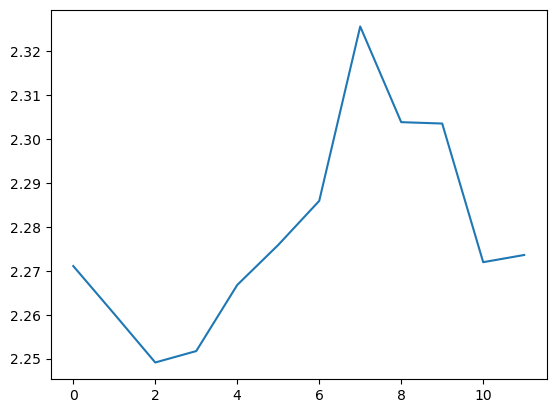

In [37]:
plt.plot(np.nanmean(climatology_surface_means[:,var_index],axis=(-1,-2)))